In [1]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sqlite3 as db
import pandas as pd
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import cycle, islice
from statistics import variance
import seaborn as sns

# Tujuan/objektif:
## 1. Urutan besar nominal penjualan kategori produk di 2018;
## 2. Daerah kota pembeli dengan total belanja terbanyak & terendah di tiap kategori produk;
## 3. Tren pembelian produk pada tahun 2018 di kota dengan penjualan kategori produk tertinggi.

# 0. Data Selection & Cleaning
Memilah tabel data mana saja yang akan digunakan untuk melakukan analisis sesuai tujuan.

In [3]:
conn = db.connect('/content/drive/MyDrive/Dataset Project Pacmann.ai/olist.db')

In [4]:
cur = conn.cursor()

## **Products Dataset**

### Table Overview

In [5]:
df_product = pd.read_sql_query('SELECT * FROM olist_products_dataset', conn)
df_product.set_index("index", inplace=True)
df_product.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
index,,,,,,,,,
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### Inspect Data Type

In [6]:
#@title Shows Data Type
df_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


In [7]:
#@title Convert Object DType into String DType
df_product[['product_id', 'product_category_name']] = df_product[['product_id', 'product_category_name']].astype(str)
print(df_product.dtypes)

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object


### Fixing Mispelled Data

#### Detecting Mispelled Data

In [8]:
# find the unique values
unique_val = df_product["product_category_name"].unique()

# set the threshold for the Levenshtein distance
threshold = 2

# create an empty list to store the almost similar strings
almost_similar = []

# loop over the unique values and compare each value with the others
for i in range(len(unique_val)):
    for j in range(i+1, len(unique_val)):
        if distance(unique_val[i], unique_val[j]) <= threshold:
            almost_similar.append((unique_val[i], unique_val[j]))

# print the result
print(almost_similar)

[('eletrodomesticos', 'eletrodomesticos_2'), ('casa_conforto', 'casa_conforto_2')]


#### Correcting Mispelled Data

In [9]:
# correcting mispelled data
fixes = {'eletrodomesticos_2': 'eletrodomesticos', 'casa_conforto_2': 'casa_conforto'}
df_product = df_product.replace(fixes)
df_product["product_category_name"].unique()

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio', 'None',
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',


### Handling Missing Value

In [10]:
df_product.isna().sum()

product_id                      0
product_category_name           0
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

## **Order Items Dataset**

### Order Table Overview

In [11]:
df_order_item = pd.read_sql_query('SELECT * FROM olist_order_items_dataset', conn)
df_order_item.set_index("index", inplace=True)
df_order_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
index,,,,,,,
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### Inspect Data Type

In [12]:
df_order_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.9+ MB


### Handling Missing Value

In [13]:
df_order_item.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [69]:
# highest order_item_id = the number of item purchased in the same order
# so, the duplicates of order_id won't be removed for now
duplicates = df_order_item[df_order_item.duplicated(subset='order_id', keep=False)]
print(duplicates)

                                order_id  order_item_id  \
index                                                     
13      0008288aa423d2a3f00fcb17cd7d8719              1   
14      0008288aa423d2a3f00fcb17cd7d8719              2   
32      00143d0f86d6fbd9f9b38ab440ac16f5              1   
33      00143d0f86d6fbd9f9b38ab440ac16f5              2   
34      00143d0f86d6fbd9f9b38ab440ac16f5              3   
...                                  ...            ...   
112635  fff8287bbae429a99bb7e8c21d151c41              2   
112640  fffb9224b6fc7c43ebb0904318b10b5f              1   
112641  fffb9224b6fc7c43ebb0904318b10b5f              2   
112642  fffb9224b6fc7c43ebb0904318b10b5f              3   
112643  fffb9224b6fc7c43ebb0904318b10b5f              4   

                              product_id                         seller_id  \
index                                                                        
13      368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100  

## **Product Cat. Translation**

### Table Overview

In [14]:
df_trans = pd.read_sql_query('SELECT * FROM product_category_name_translation', conn)
df_trans.set_index("index", inplace=True)
df_trans.head()

,product_category_name,product_category_name_english
index,,
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [15]:
print(df_trans)

               product_category_name product_category_name_english
index                                                             
0                       beleza_saude                 health_beauty
1             informatica_acessorios         computers_accessories
2                         automotivo                          auto
3                    cama_mesa_banho                bed_bath_table
4                   moveis_decoracao               furniture_decor
...                              ...                           ...
66                            flores                       flowers
67                artes_e_artesanato         arts_and_craftmanship
68                   fraldas_higiene           diapers_and_hygiene
69     fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70                seguros_e_servicos         security_and_services

[71 rows x 2 columns]


### Inspect Data Type

In [16]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


### Fixing Mispelled Data

In [17]:
# before correction
df_trans["product_category_name_english"].unique()

array(['health_beauty', 'computers_accessories', 'auto', 'bed_bath_table',
       'furniture_decor', 'sports_leisure', 'perfumery', 'housewares',
       'telephony', 'watches_gifts', 'food_drink', 'baby', 'stationery',
       'tablets_printing_image', 'toys', 'fixed_telephony',
       'garden_tools', 'fashion_bags_accessories', 'small_appliances',
       'consoles_games', 'audio', 'fashion_shoes', 'cool_stuff',
       'luggage_accessories', 'air_conditioning',
       'construction_tools_construction',
       'kitchen_dining_laundry_garden_furniture',
       'costruction_tools_garden', 'fashion_male_clothing', 'pet_shop',
       'office_furniture', 'market_place', 'electronics',
       'home_appliances', 'party_supplies', 'home_confort',
       'costruction_tools_tools', 'agro_industry_and_commerce',
       'furniture_mattress_and_upholstery', 'books_technical',
       'home_construction', 'musical_instruments',
       'furniture_living_room', 'construction_tools_lights',
       'indust

#### Detecting Mispelled Data

In [18]:
# find the unique values
unique_val = df_trans['product_category_name_english'].unique()

# set the threshold for the Levenshtein distance
threshold = 2

# create an empty list to store the almost similar strings
almost_similar = []

# loop over the unique values and compare each value with the others
for i in range(len(unique_val)):
    for j in range(i+1, len(unique_val)):
        if distance(unique_val[i], unique_val[j]) <= threshold:
            almost_similar.append((unique_val[i], unique_val[j]))

# print the result
print(almost_similar)

[('auto', 'audio'), ('auto', 'art'), ('home_appliances', 'home_appliances_2')]


#### Correcting Mispelled Data

In [64]:
# correcting mispelled data
fix = {"home_confort": "home_comfort", "home_appliances_2": "home_appliances", "home_comfort_2": "home_comfort"}
df_trans = df_trans.replace(fix)
df_trans["product_category_name_english"].unique()

array(['health_beauty', 'computers_accessories', 'auto', 'bed_bath_table',
       'furniture_decor', 'sports_leisure', 'perfumery', 'housewares',
       'telephony', 'watches_gifts', 'food_drink', 'baby', 'stationery',
       'tablets_printing_image', 'toys', 'fixed_telephony',
       'garden_tools', 'fashion_bags_accessories', 'small_appliances',
       'consoles_games', 'audio', 'fashion_shoes', 'cool_stuff',
       'luggage_accessories', 'air_conditioning',
       'construction_tools_construction',
       'kitchen_dining_laundry_garden_furniture',
       'costruction_tools_garden', 'fashion_male_clothing', 'pet_shop',
       'office_furniture', 'market_place', 'electronics',
       'home_appliances', 'party_supplies', 'home_comfort',
       'costruction_tools_tools', 'agro_industry_and_commerce',
       'furniture_mattress_and_upholstery', 'books_technical',
       'home_construction', 'musical_instruments',
       'furniture_living_room', 'construction_tools_lights',
       'indust

### Handling Missing Values

In [65]:
df_trans.isna().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

### Showing Duplicated Data

In [66]:
df_trans[df_trans.duplicated()].sort_values(by = ['product_category_name_english'])

,product_category_name,product_category_name_english
index,,


## **Order Dataset**

In [22]:
#@title Table Overview
df_order = pd.read_sql_query('SELECT * FROM olist_order_dataset', conn)
df_order.set_index("index", inplace=True)
df_order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
index,,,,,,,,
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


#### Handling Missing Values

In [23]:
df_order.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

## **Order Customer Dataset**

### Table Overview

In [24]:
df_customer = pd.read_sql_query('SELECT * FROM olist_order_customer_dataset', conn)
df_customer.set_index("index", inplace=True)
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
index,,,,,
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Handling Missing Values

In [25]:
df_customer.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

## Merge & Clean Product, Item, & Product C. Translation Dataset

In [106]:
df_all = pd.merge(df_order_item, df_product, on="product_id", how="right")
df_all = pd.merge(df_all, df_trans, on="product_category_name", how="left")
df_all = pd.merge(df_all, df_order, on="order_id", how="right")
df_all = pd.merge(df_all, df_customer, on="customer_id", how="left")
df_all.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,...,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,...,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,...,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,59.0,468.0,...,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,38.0,316.0,...,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


### Check the Untranslated Product Name

In [107]:
# Compare Portuguese and English ver. Availability
trans_check = df_all[["product_category_name","product_category_name_english"]].loc[
(df_all["product_category_name"].notna()) 
& (df_all["product_category_name_english"].isna())]

# Shows the Portuguese Column with NaN English
trans_check['product_category_name'].unique()

array(['None', 'portateis_cozinha_e_preparadores_de_alimentos',
       'pc_gamer'], dtype=object)

### Fix the Translation

In [108]:
fix = {"pc_gamer":"pc_gamer", 
         "portateis_cozinha_e_preparadores_de_alimentos":
         "kitchen_and_food_preparators_portables", None: "others", 'None': "others"}
df_all["product_category_name_english"] = df_all["product_category_name_english"].fillna(df_all["product_category_name"].map(fix))

# Recompute trans_check after fillna operation
trans_check = df_all[["product_category_name","product_category_name_english"]].loc[(df_all["product_category_name"].notna()) 
& (df_all["product_category_name_english"].isna())]

### Check Untranslated Words Left

In [109]:
trans_check

,product_category_name,product_category_name_english


In [110]:
# These code shows which word hasn't been translated
trans_check['product_category_name'].unique()

array([], dtype=object)

In [111]:
(df_all['product_category_name_english'] == 'others').sum()

1603

### Replace the Portuguese Product Column with English Column

In [112]:
# Drop Portuguese Column
df_all = df_all.drop('product_category_name', axis=1)

# Rename English Column & order_item_id
df_all = df_all.rename(columns={'product_category_name_english': 'product_category'})

### Eliminating Unnecessary Data Columns

In [113]:
# we still need order_id to calculate price * max order_item_id number
df_all = df_all.drop(labels=['customer_id', 'product_id', 'seller_id', 'customer_unique_id', 
                             'shipping_limit_date', 'product_name_lenght', 
                             'product_description_lenght', 'product_photos_qty', 
                             'product_weight_g', 'product_length_cm', 'product_height_cm',
                             'product_width_cm', 'order_approved_at', 'order_delivered_carrier_date',
                             'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)
df_all

,order_id,order_item_id,price,freight_value,product_category,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,29.99,8.72,housewares,delivered,2017-10-02 10:56:33,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,118.70,22.76,perfumery,delivered,2018-07-24 20:41:37,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,159.90,19.22,auto,delivered,2018-08-08 08:38:49,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,45.00,27.20,pet_shop,delivered,2017-11-18 19:28:06,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,19.90,8.72,stationery,delivered,2018-02-13 21:18:39,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1.0,174.90,20.10,baby,delivered,2018-02-06 12:58:58,11722,praia grande,SP
113421,83c1379a015df1e13d02aae0204711ab,1.0,205.99,65.02,home_appliances,delivered,2017-08-27 14:46:43,45920,nova vicosa,BA
113422,11c177c8e97725db2631073c19f07b62,1.0,179.99,40.59,computers_accessories,delivered,2018-01-08 21:28:27,28685,japuiba,RJ
113423,11c177c8e97725db2631073c19f07b62,2.0,179.99,40.59,computers_accessories,delivered,2018-01-08 21:28:27,28685,japuiba,RJ


### Calculate Sales each Order



In [114]:
# Step 1: Grouping DataFrame by "order_id" column
grouped = df_all.groupby('order_id').agg({'order_item_id': 'max'})

# Step 2: Merging the aggregated result with the original DataFrame
df_all = df_all.merge(grouped, on='order_id')

# Step 3: Rename the aggregated column for clarity
df_all.rename(columns={'order_item_id_x': 'order_item_id', 'order_item_id_y': 'quantity'}, inplace=True)

# Step 4: Calculating sales by multiplying price with the highest number of "order_item_id"
df_all['sales'] = df_all['price'] * df_all['quantity']

# shows the dataframe to verify the new column has been added
df_all

,order_id,order_item_id,price,freight_value,product_category,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,quantity,sales
0,e481f51cbdc54678b7cc49136f2d6af7,1.0,29.99,8.72,housewares,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,1.0,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,1.0,118.70,22.76,perfumery,delivered,2018-07-24 20:41:37,47813,barreiras,BA,1.0,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,1.0,159.90,19.22,auto,delivered,2018-08-08 08:38:49,75265,vianopolis,GO,1.0,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,1.0,45.00,27.20,pet_shop,delivered,2017-11-18 19:28:06,59296,sao goncalo do amarante,RN,1.0,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,1.0,19.90,8.72,stationery,delivered,2018-02-13 21:18:39,9195,santo andre,SP,1.0,19.90
...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1.0,174.90,20.10,baby,delivered,2018-02-06 12:58:58,11722,praia grande,SP,1.0,174.90
113421,83c1379a015df1e13d02aae0204711ab,1.0,205.99,65.02,home_appliances,delivered,2017-08-27 14:46:43,45920,nova vicosa,BA,1.0,205.99
113422,11c177c8e97725db2631073c19f07b62,1.0,179.99,40.59,computers_accessories,delivered,2018-01-08 21:28:27,28685,japuiba,RJ,2.0,359.98
113423,11c177c8e97725db2631073c19f07b62,2.0,179.99,40.59,computers_accessories,delivered,2018-01-08 21:28:27,28685,japuiba,RJ,2.0,359.98


### Remove column that no longer in use

In [115]:
# Remove order_id, order_item_id & freight_value after sales being calculated
df_all = df_all.drop(labels=['order_id', 'order_item_id', 'freight_value'], axis=1)
df_all

,price,product_category,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,quantity,sales
0,29.99,housewares,delivered,2017-10-02 10:56:33,3149,sao paulo,SP,1.0,29.99
1,118.70,perfumery,delivered,2018-07-24 20:41:37,47813,barreiras,BA,1.0,118.70
2,159.90,auto,delivered,2018-08-08 08:38:49,75265,vianopolis,GO,1.0,159.90
3,45.00,pet_shop,delivered,2017-11-18 19:28:06,59296,sao goncalo do amarante,RN,1.0,45.00
4,19.90,stationery,delivered,2018-02-13 21:18:39,9195,santo andre,SP,1.0,19.90
...,...,...,...,...,...,...,...,...,...
113420,174.90,baby,delivered,2018-02-06 12:58:58,11722,praia grande,SP,1.0,174.90
113421,205.99,home_appliances,delivered,2017-08-27 14:46:43,45920,nova vicosa,BA,1.0,205.99
113422,179.99,computers_accessories,delivered,2018-01-08 21:28:27,28685,japuiba,RJ,2.0,359.98
113423,179.99,computers_accessories,delivered,2018-01-08 21:28:27,28685,japuiba,RJ,2.0,359.98


### Inspect Numbers of Non-Null

In [116]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   price                     112650 non-null  float64
 1   product_category          112650 non-null  object 
 2   order_status              113425 non-null  object 
 3   order_purchase_timestamp  113425 non-null  object 
 4   customer_zip_code_prefix  113425 non-null  int64  
 5   customer_city             113425 non-null  object 
 6   customer_state            113425 non-null  object 
 7   quantity                  112650 non-null  float64
 8   sales                     112650 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 8.7+ MB


### Drop Every Row with Missing Values

In [118]:
df_all = df_all[~df_all['quantity'].isna()]
df_all = df_all[~df_all['price'].isna()]
df_all = df_all[~df_all['product_category'].isna()]
df_all = df_all[~df_all['order_status'].isna()]
df_all = df_all[~df_all['order_purchase_timestamp'].isna()]
df_all = df_all[~df_all['customer_city'].isna()]
df_all = df_all[~df_all['customer_state'].isna()]
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 113424
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   price                     112650 non-null  float64
 1   product_category          112650 non-null  object 
 2   order_status              112650 non-null  object 
 3   order_purchase_timestamp  112650 non-null  object 
 4   customer_zip_code_prefix  112650 non-null  int64  
 5   customer_city             112650 non-null  object 
 6   customer_state            112650 non-null  object 
 7   quantity                  112650 non-null  float64
 8   sales                     112650 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 8.6+ MB


### Check Missing Values on Merged Table

In [119]:
df_all.isna().sum()

price                       0
product_category            0
order_status                0
order_purchase_timestamp    0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
quantity                    0
sales                       0
dtype: int64

### Looking for Unique Value

In [120]:
#@title Order Item ID
df_all['quantity'].unique()

array([ 1.,  2.,  4.,  5.,  3.,  6.,  7., 12.,  8., 11.,  9., 14., 15.,
       13., 10., 20., 21.])

In [121]:
#@title Shows the Order Status before Updated
df_all['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'canceled',
       'unavailable', 'approved'], dtype=object)

### Exclude Orders that Canceled & Unavailable

In [122]:
# Create Boolean Mask as Conditional Exception
mask1 = df_all['order_status'] != 'canceled'
mask2 = df_all['order_status'] != 'unavailable'
mask = mask1 & mask2

# Use the masks to index the DataFrame
df_all = df_all[mask]

In [123]:
# Shows the Updated Order Status
df_all['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'approved'],
      dtype=object)

In [147]:
df_all.tail()

,price,product_category,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,quantity,sales
113420,174.90,baby,delivered,2018-02-06 12:58:58,11722,praia grande,SP,1.0,174.90
113421,205.99,home_appliances,delivered,2017-08-27 14:46:43,45920,nova vicosa,BA,1.0,205.99
113422,179.99,computers_accessories,delivered,2018-01-08 21:28:27,28685,japuiba,RJ,2.0,359.98
113423,179.99,computers_accessories,delivered,2018-01-08 21:28:27,28685,japuiba,RJ,2.0,359.98
113424,68.50,health_beauty,delivered,2018-03-08 20:57:30,83750,lapa,PR,1.0,68.50


### Grouping and Aggregation

#### Calculate Price based on Product Category Overall time

In [148]:
df_cate_sales = df_all[["product_category","sales"]].groupby(
    "product_category").sum().sort_values(
    "product_category").reset_index()

df_cate_sales = df_cate_sales.rename(columns={"sales": "cate_sales"})
df_cate_sales = df_cate_sales.sort_values('cate_sales', ascending=False)

df_cate_sales

,product_category,cate_sales
43,health_beauty,1433617.25
7,bed_bath_table,1421147.41
15,computers_accessories,1355164.15
71,watches_gifts,1305931.89
66,sports_leisure,1169353.20
...,...,...
59,pc_gamer,1874.94
35,flowers,1810.44
11,cds_dvds_musicals,910.00
29,fashion_childrens_clothes,649.83


In [126]:
#@title Total Sales Overall Time
sum_sales = df_cate_sales['cate_sales'].sum()
formatted_sum_sales = "{:,.2f}".format(sum_sales)
print(f"Total Sales Overall Time: US$ {formatted_sum_sales}")


Total Sales Overall Time: US$ 17,094,625.30


### Filter Merged Table into 2018 only

In [149]:
# convert the string to datetime object
df_all['order_purchase_timestamp'] = \
pd.to_datetime(df_all['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

# filter data for 2018
df_2018 = df_all[df_all['order_purchase_timestamp'].dt.year == 2018]

# sort data in ascending order by datetime
df_2018 = df_2018.sort_values(by='order_purchase_timestamp', ascending=True)

df_2018

,price,product_category,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,quantity,sales
106276,148.00,pet_shop,delivered,2018-01-01 02:48:41,57015,maceio,AL,1.0,148.00
81788,151.20,baby,delivered,2018-01-01 08:37:46,29600,afonso claudio,ES,1.0,151.20
14238,43.20,sports_leisure,delivered,2018-01-01 08:45:04,12215,sao jose dos campos,SP,1.0,43.20
106646,139.00,garden_tools,delivered,2018-01-01 09:36:21,72872,valparaiso de goias,GO,1.0,139.00
30255,99.00,fashion_bags_accessories,delivered,2018-01-01 10:24:03,2998,sao paulo,SP,1.0,99.00
...,...,...,...,...,...,...,...,...,...
34291,209.00,kitchen_dining_laundry_garden_furniture,delivered,2018-08-29 14:18:23,80045,curitiba,PR,2.0,418.00
35930,45.90,health_beauty,delivered,2018-08-29 14:18:28,38600,paracatu,MG,1.0,45.90
79408,24.90,party_supplies,delivered,2018-08-29 14:52:00,9541,sao caetano do sul,SP,1.0,24.90
100363,84.99,computers_accessories,delivered,2018-08-29 15:00:37,13483,limeira,SP,1.0,84.99


#### Calculate Price based on Product Category in 2018

In [128]:
# Product Category in 2018 only
df_cate_sales_2018 = df_all[df_all['order_purchase_timestamp'].dt.year == 2018]
df_cate_sales_2018 = df_cate_sales_2018[["product_category","sales"]].groupby(
    "product_category").sum().sort_values(
    "product_category").reset_index()

df_cate_sales_2018 = df_cate_sales_2018.rename(columns={"sales": "cate_sales"})
df_cate_sales_2018 = df_cate_sales_2018.sort_values('cate_sales', ascending=False)

df_cate_sales_2018

,product_category,cate_sales
43,health_beauty,895713.76
70,watches_gifts,781349.52
7,bed_bath_table,750822.62
15,computers_accessories,747234.84
65,sports_leisure,629997.53
...,...,...
59,pc_gamer,1354.98
51,la_cuisine,1061.00
32,fashion_sport,429.40
29,fashion_childrens_clothes,249.95


In [129]:
#@title Total Sales in 2018
df_cate_sales_2018['cate_sales'].sum()

sum_sales = df_cate_sales_2018['cate_sales'].sum()
formatted_sum_sales = "{:,.2f}".format(sum_sales)
print(f"Total Sales Overall Time: US$ {formatted_sum_sales}")

Total Sales Overall Time: US$ 9,287,254.85


### Sales Table Breakdown

#### Breakdown the Sales based on Product Category in 2018

In [154]:
# grouping sales based on product category 2018
df_sales = df_2018[["product_category","sales"]].groupby(
    ["product_category"]).sum().sort_values(
    "product_category").reset_index()

# sorting sales value ascending
df_sales = df_sales.sort_values("sales", ascending=False)

# rename sales into category sales
df_sales = df_cate_sales_2018.rename(columns={"sales": "cate_sales"})

# reset index after sorting city_sales value
df_sales.reset_index(drop=True, inplace=True)

df_sales


,product_category,cate_sales
0,health_beauty,895713.76
1,watches_gifts,781349.52
2,bed_bath_table,750822.62
3,computers_accessories,747234.84
4,sports_leisure,629997.53
...,...,...
66,pc_gamer,1354.98
67,la_cuisine,1061.00
68,fashion_sport,429.40
69,fashion_childrens_clothes,249.95


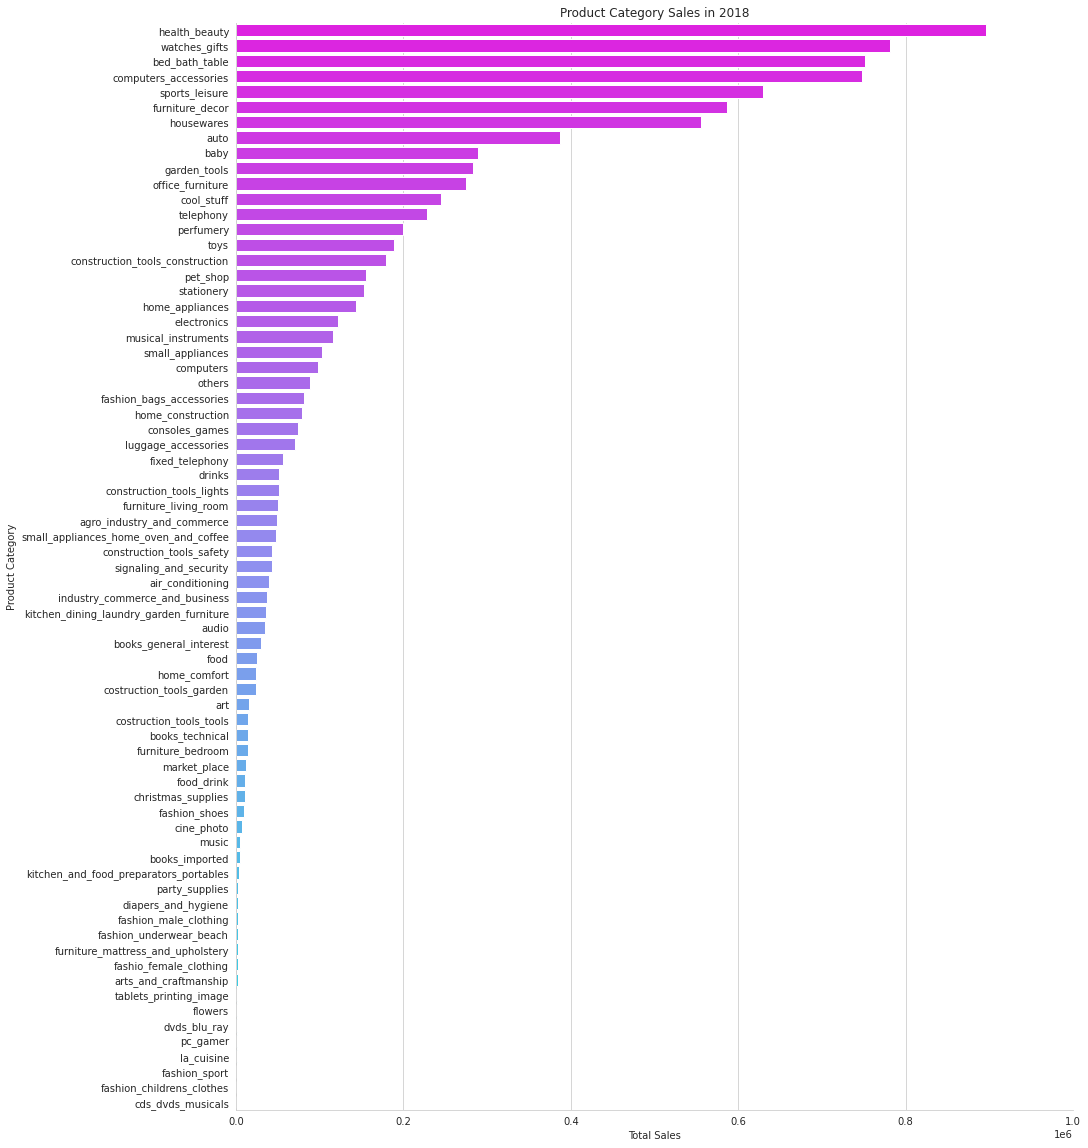

In [155]:
#@title Visualization: Product Category Sales in 2018

import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 20))

sns.barplot(y="product_category", x="cate_sales", data=df_sales, color="b", palette="cool_r")
sns.set_style("whitegrid")

ax.set(xlim=(0, 1_000_000), ylabel="Product Category", xlabel="Total Sales", title="Product Category Sales in 2018")

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)


#### Breakdown the Sales of Product Category based on Customer City in 2018

In [132]:
df_city_sales = df_2018[["product_category","customer_city","sales"]].groupby(
    ["product_category", "customer_city"]).sum().sort_values(
    "product_category").reset_index()

df_city_sales = df_city_sales.rename(columns={"sales": "city_sales"})

df_city_sales

,product_category,customer_city,city_sales
0,agro_industry_and_commerce,alto piquiri,412.00
1,agro_industry_and_commerce,ribeirao pires,19.50
2,agro_industry_and_commerce,praia grande,58.50
3,agro_industry_and_commerce,porto alegre do norte,410.00
4,agro_industry_and_commerce,porto alegre,68.85
...,...,...,...
16674,watches_gifts,fortaleza,8809.26
16675,watches_gifts,fortim,179.00
16676,watches_gifts,fraiburgo,108.00
16677,watches_gifts,feira de santana,2292.90


#### Breakdown the Sales based on Product Category, Customer City & Datetime in 2018

In [133]:
df_city_sales = df_2018[["product_category", "customer_city", "order_purchase_timestamp", "sales"]].groupby(
    ["product_category", "customer_city"]).agg({
    "order_purchase_timestamp": "first",
    "sales": "sum"
    }).reset_index()

df_city_sales = df_city_sales.rename(columns={"sales": "city_sales"})

df_city_sales

,product_category,customer_city,order_purchase_timestamp,city_sales
0,agro_industry_and_commerce,alto piquiri,2018-01-30 13:29:16,412.0
1,agro_industry_and_commerce,americana,2018-04-25 17:53:32,228.0
2,agro_industry_and_commerce,amparo,2018-01-17 17:34:42,412.0
3,agro_industry_and_commerce,andradas,2018-04-27 08:44:30,410.0
4,agro_industry_and_commerce,andradina,2018-07-24 21:30:58,109.9
...,...,...,...,...
16674,watches_gifts,votorantim,2018-03-08 09:42:27,203.9
16675,watches_gifts,votuporanga,2018-07-20 00:10:37,122.0
16676,watches_gifts,xavantina,2018-05-30 15:03:06,49.9
16677,watches_gifts,xaxim,2018-07-23 18:19:11,55.0


In [134]:
len(df_city_sales['product_category'].unique())

71

In [135]:
len(df_city_sales['customer_city'].unique())

3274

# 1. City with Highest Product Category Sales in 2018

In [152]:
#@title Data Frame:
# find and shows product category with highest sales based on city
df_city_category = df_city_sales.groupby('product_category')['city_sales'].idxmax()
df_high = df_city_sales.loc[df_city_category, ['product_category', 'customer_city', 'city_sales']].sort_values(
    "product_category").reset_index()

# add cate_sales as comparison to highest city_sales
df_high['cate_sales'] = df_cate_sales_2018['cate_sales']

# create percentage column
df_high['percentage(%)'] = df_high['city_sales'] / df_cate_sales_2018['cate_sales']

# multiply by 100 for % form, then sorting its value descending
df_high['percentage(%)'] = (df_high['percentage(%)'] * 100).round(2)
df_high = df_high.sort_values("city_sales", ascending=False)

# reset index after sorting city_sales value
df_high.reset_index(drop=True, inplace=True)
df_high.drop(columns=['index'], axis=1, inplace=True)

# call the table
df_high

,product_category,customer_city,city_sales,cate_sales,percentage(%)
0,computers_accessories,sao paulo,168172.40,747234.84,22.51
1,health_beauty,sao paulo,164350.36,895713.76,18.35
2,bed_bath_table,sao paulo,140695.07,750822.62,18.74
3,watches_gifts,sao paulo,108880.13,781349.52,13.93
4,sports_leisure,sao paulo,93143.08,629997.53,14.78
...,...,...,...,...,...
66,arts_and_craftmanship,brusque,289.49,1730.82,16.73
67,fashion_underwear_beach,sao paulo,274.80,2554.80,10.76
68,fashion_childrens_clothes,sao paulo,169.97,249.95,68.00
69,fashion_sport,atibaia,119.80,429.40,27.90


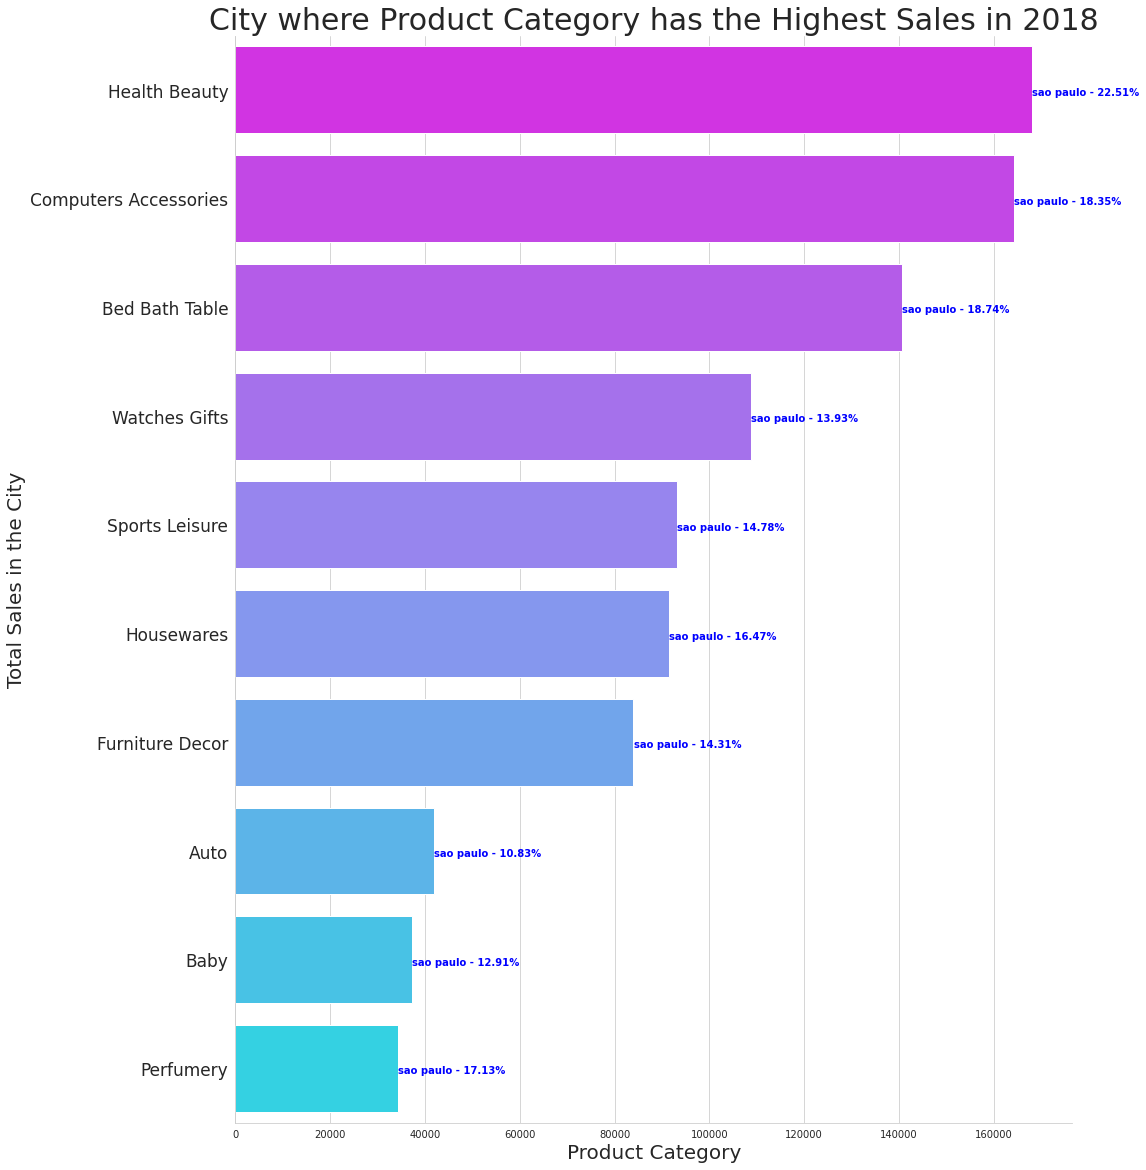

In [153]:
#@title Visualization:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='city_sales', y='product_category', data=df_high.head(10), 
            palette="cool_r")
sns.set_style("whitegrid")

ax.set(ylabel='Total Sales in the City', xlabel='Product Category', 
       title='City where Product Category has the Highest Sales in 2018')
plt.title('City where Product Category has the Highest Sales in 2018', fontsize=30)

for spine in ["top", "right"]:
  ax.spines[spine].set_visible(False)

for i, v in enumerate(df_high.head(10)["city_sales"]):
  ax.text(v + 3, i + .05, str(df_high.head(10)["customer_city"][i]) + " - " + 
          str(df_high.head(10)["percentage(%)"][i]) + "%", color='blue', 
          fontweight='bold')

ax.set_yticklabels(['Health Beauty', 'Computers Accessories', 'Bed Bath Table', 
                    'Watches Gifts', 'Sports Leisure', 'Housewares', 
                    'Furniture Decor', 'Auto', 'Baby', 'Perfumery'])

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.tick_params(axis = 'y', labelsize = 17)

plt.show()

# 2. City where Product Category has the Lowest Sales in 2018

In [156]:
#@title Data Frame:
# find and shows product category with lowest sales based on city
df_city_category = df_city_sales.groupby('product_category')['city_sales'].idxmin()
df_low = df_city_sales.loc[df_city_category, ['product_category', 'customer_city', 'city_sales']].sort_values(
    "product_category").reset_index()

# add cate_sales as comparison to lowest city_sales
df_low['cate_sales'] = df_cate_sales_2018['cate_sales']

# create percentage column
df_low['percentage(%)'] = df_low['city_sales'] / df_cate_sales_2018['cate_sales']

# multiply by 100 for % form, then sorting its value ascending
df_low['percentage(%)'] = (df_low['percentage(%)'] * 100).round(4)
df_low = df_low.sort_values("city_sales", ascending=True)

# reset index after sorting city_sales value
df_low.reset_index(drop=True, inplace=True)
df_low.drop(columns=['index'], axis=1, inplace=True)

# call the table
df_low

,product_category,customer_city,city_sales,cate_sales,percentage(%)
0,construction_tools_construction,hortolandia,0.85,179324.14,0.0005
1,others,barretos,3.00,88890.78,0.0034
2,music,extrema,3.85,4553.83,0.0845
3,consoles_games,esteio,5.18,73529.12,0.0070
4,stationery,polo petroquimico de triunfo,5.60,153382.50,0.0037
...,...,...,...,...,...
66,fashion_childrens_clothes,blumenau,79.98,249.95,31.9984
67,furniture_bedroom,ubaitaba,80.00,13736.05,0.5824
68,la_cuisine,taboao da serra,112.00,1061.00,10.5561
69,pc_gamer,ibiraiaras,219.00,1354.98,16.1626


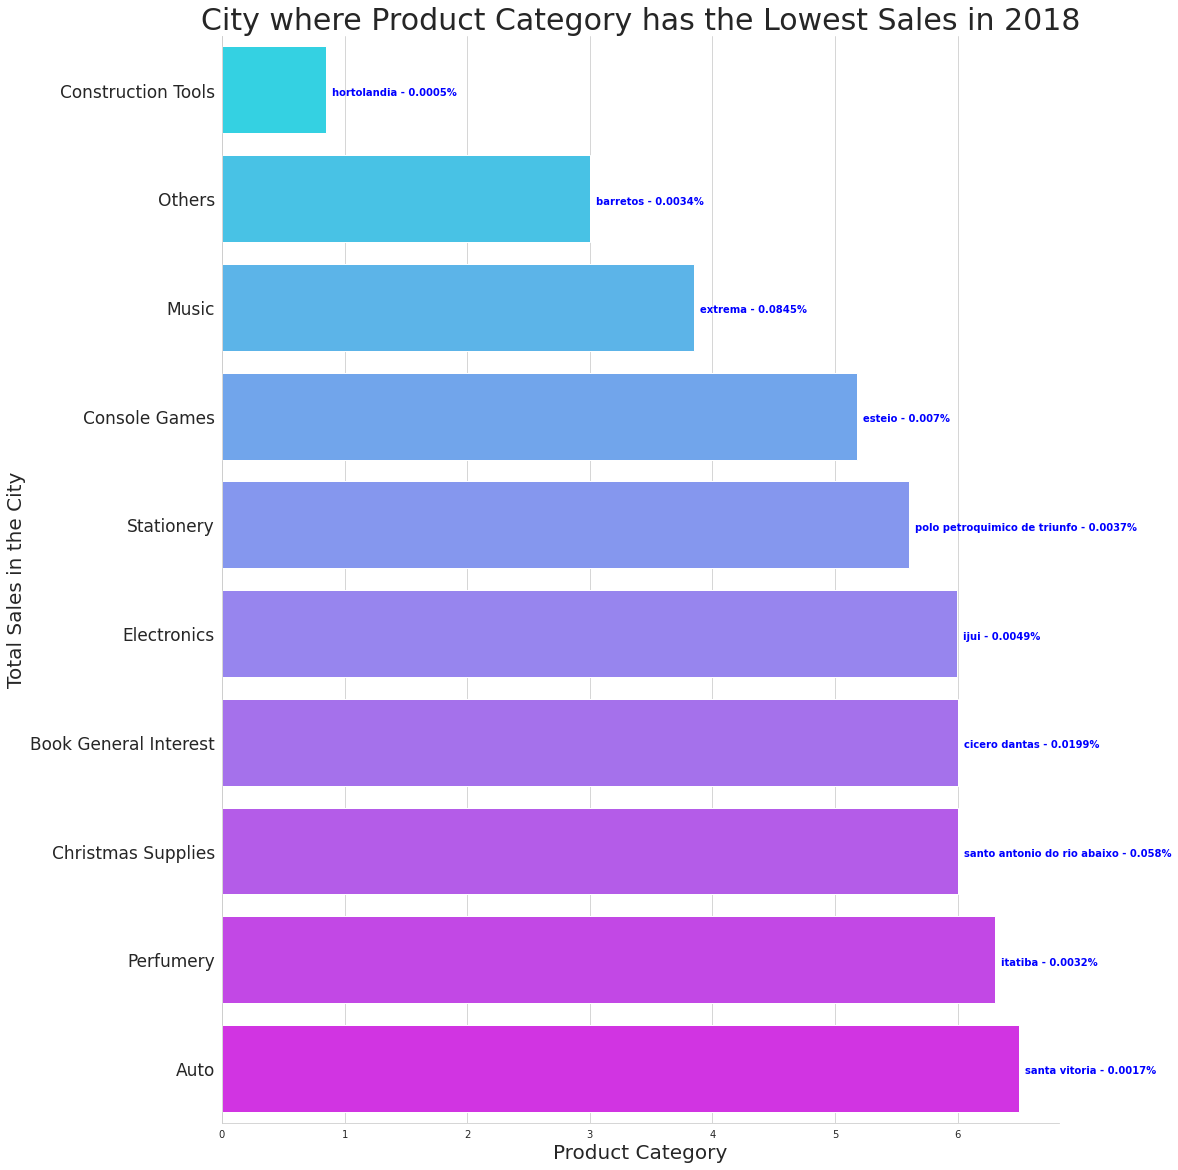

In [139]:
#@title Visualization:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='city_sales', y='product_category', data=df_low.head(10), 
            palette="cool")
sns.set_style("whitegrid")

ax.set(ylabel='Total Sales in the City', xlabel='Product Category', 
       title='City where Product Category has the Lowest Sales in 2018')
plt.title('City where Product Category has the Lowest Sales in 2018', fontsize=30)

for spine in ["top", "right"]:
  ax.spines[spine].set_visible(False)

for i, v in enumerate(df_low.head(10)["city_sales"]):
  ax.text(v + 0.05, i + .05, str(df_low.head(10)["customer_city"][i]) + " - " + 
          str(df_low.head(10)["percentage(%)"][i]) + "%", color='blue', 
          fontweight='bold')

ax.set_yticklabels(['Construction Tools', 'Others', 'Music', 
                    'Console Games', 'Stationery', 'Electronics', 
                    'Book General Interest', 'Christmas Supplies', 'Perfumery', 'Auto'])

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.tick_params(axis = 'y', labelsize = 17)

plt.show()

# 3. Sales Trend in 2018

## Breakdown Product Category Sales each Month in 2018

### 'Specify the Trend' Table
So here are trends of top 3 sales product category in 2018, from "Product Category with its Highest Sales in 2018 based on City"





In [140]:
#@title City where Product Category has the Highest Sales in 2018" Table
# find and shows product category with highest sales based on city
df_city_category = df_city_sales.groupby('product_category')['city_sales'].idxmax()
df_high = df_city_sales.loc[df_city_category, ['product_category', 'customer_city', 'city_sales']].sort_values(
    "product_category").reset_index()

# add cate_sales as comparison to highest city_sales
df_high['cate_sales'] = df_cate_sales_2018['cate_sales']

# create percentage column
df_high['percentage(%)'] = df_high['city_sales'] / df_cate_sales_2018['cate_sales']

# multiply by 100 for % form, then sorting its value descending
df_high['percentage(%)'] = (df_high['percentage(%)'] * 100).round(2)
df_high = df_high.sort_values("city_sales", ascending=False)

# reset index after sorting city_sales value
df_high.reset_index(drop=True, inplace=True)
df_high.drop(columns=['index'], axis=1, inplace=True)

df_high.head(3)

,product_category,customer_city,city_sales,cate_sales,percentage(%)
0,computers_accessories,sao paulo,168172.40,747234.84,22.51
1,health_beauty,sao paulo,164350.36,895713.76,18.35
2,bed_bath_table,sao paulo,140695.07,750822.62,18.74


In [141]:
#@title Top #1: Health and Beauty 2018 (Sao Paulo)
df_hbe = df_2018[(df_2018['product_category'] == 'health_beauty') & (df_2018['customer_city'] == 'sao paulo')]
df_hbe['month_num'] = pd.to_datetime(df_hbe['order_purchase_timestamp']).dt.month
df_hbe = df_hbe.groupby(by=['month_num'])['sales'].sum().reset_index(name='monthly_sales')
df_hbe = df_hbe.sort_values("month_num", ascending=True)

total_row = pd.Series({'month_num': 'Total', 'monthly_sales': df_hbe['monthly_sales'].sum()})
df_hbe_total = df_hbe.append(total_row, ignore_index=True)

df_hbe_total



<ipython-input-141-0b0891e94a34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hbe['month_num'] = pd.to_datetime(df_hbe['order_purchase_timestamp']).dt.month


,month_num,monthly_sales
0,1,15343.44
1,2,12031.49
2,3,23676.60
3,4,18532.08
4,5,26090.19
5,6,19938.18
6,7,15612.74
7,8,33125.64
8,Total,164350.36


In [142]:
#@title Top #2: Computers & Accessories 2018 (Sao Paulo)
df_caa = df_2018[(df_2018['product_category'] == 'computers_accessories') & (df_2018['customer_city'] == 'sao paulo')]
df_caa['month_num'] = pd.to_datetime(df_caa['order_purchase_timestamp']).dt.month
df_caa = df_caa.groupby(by=['month_num'])['sales'].sum().reset_index(name='monthly_sales')
df_caa = df_caa.sort_values("month_num", ascending=True)

total_row = pd.Series({'month_num': 'Total', 'monthly_sales': df_caa['monthly_sales'].sum()})
df_caa_total = df_caa.append(total_row, ignore_index=True)

df_caa_total

<ipython-input-142-b3e977a9cf78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_caa['month_num'] = pd.to_datetime(df_caa['order_purchase_timestamp']).dt.month


,month_num,monthly_sales
0,1,18926.04
1,2,57383.12
2,3,37260.40
3,4,20647.41
4,5,9687.00
5,6,9256.48
6,7,6727.60
7,8,8284.35
8,Total,168172.40


In [143]:
#@title Top #3: Bed, Bath & Table 2018 (Sao Paulo)
df_bbt = df_2018[(df_2018['product_category'] == 'bed_bath_table') & (df_2018['customer_city'] == 'sao paulo')]
df_bbt['month_num'] = pd.to_datetime(df_bbt['order_purchase_timestamp']).dt.month
df_bbt = df_bbt.groupby(by=['month_num'])['sales'].sum().reset_index(name='monthly_sales')
df_bbt = df_bbt.sort_values("month_num", ascending=True)

total_row = pd.Series({'month_num': 'Total', 'monthly_sales': df_bbt['monthly_sales'].sum()})
df_bbt_total = df_bbt.append(total_row, ignore_index=True)

df_bbt_total

<ipython-input-143-a622b82ed89a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bbt['month_num'] = pd.to_datetime(df_bbt['order_purchase_timestamp']).dt.month


,month_num,monthly_sales
0,1,18696.06
1,2,13279.04
2,3,15383.87
3,4,18783.53
4,5,20517.86
5,6,14607.75
6,7,19482.66
7,8,19944.30
8,Total,140695.07


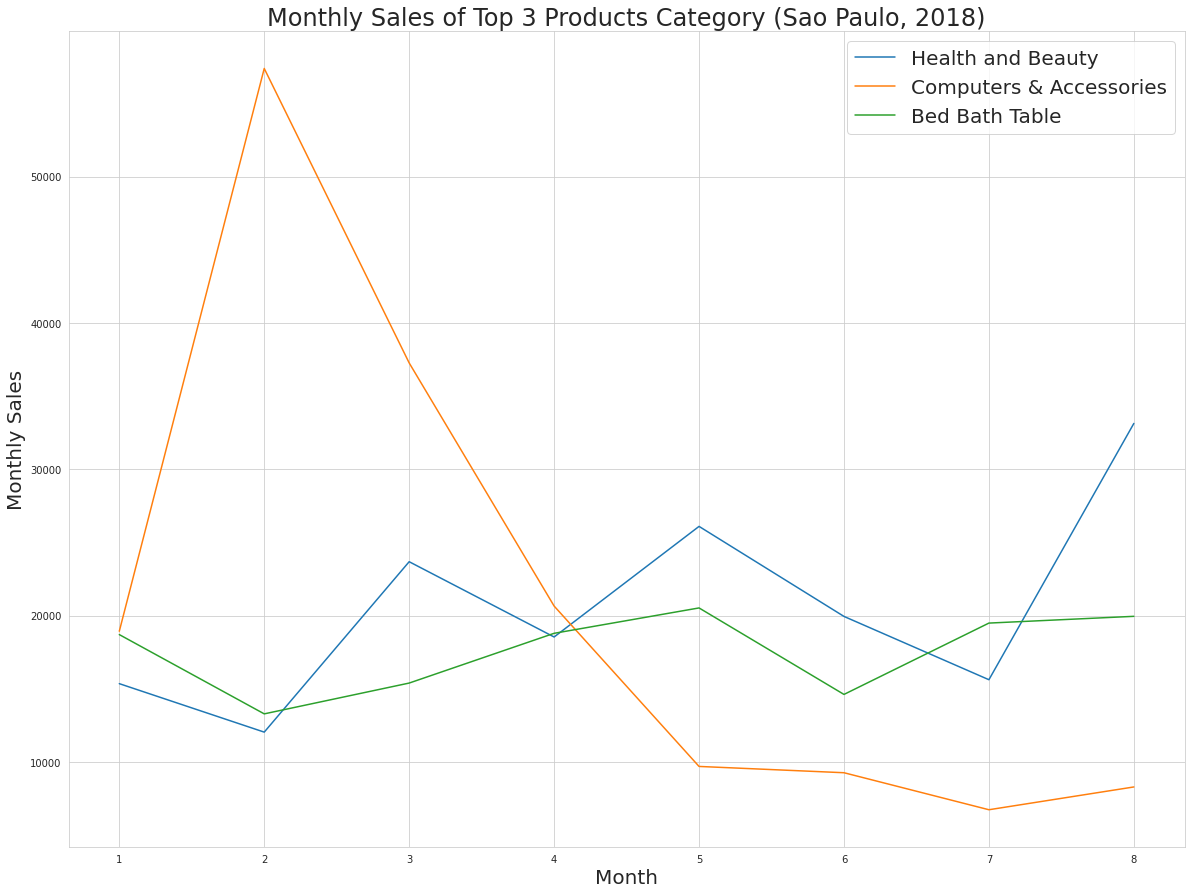

In [171]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15))

# Plot the first dataframe
plt.plot(df_hbe['month_num'], df_hbe['monthly_sales'], label='Health and Beauty')

# Plot the second dataframe
plt.plot(df_caa['month_num'], df_caa['monthly_sales'], label='Computers & Accessories')

# Plot the third dataframe
plt.plot(df_bbt['month_num'], df_bbt['monthly_sales'], label='Bed Bath Table')

# Add legend to the chart
plt.legend(fontsize=20)

# Add labels and title to the chart
plt.xlabel('Month', fontsize=20)
plt.ylabel('Monthly Sales', fontsize=20)
plt.title('Monthly Sales of Top 3 Products Category (Sao Paulo, 2018)', fontsize=24)

# Show the chart
plt.show()
